In [15]:
import torch,gc
import torchvision
from torchvision import transforms
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import os

In [16]:
gc.collect()
torch.cuda.empty_cache()

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
file_path = Path("mini_food/pizza_steak_sushi/")
train_dir = file_path/"train"
test_dir = file_path/"test"

In [19]:
from data_setup import create_dataloaders


image_transform = transforms.Compose(
    [
        transforms.Resize(size=(224,224)),
        transforms.ToTensor()
    ]
)
train_dataloader,test_dataloader,class_names = create_dataloaders(train_dir=train_dir,
                                                                  test_dir=test_dir,
                                                                  transform=image_transform,
                                                                  batch_size=32)

In [20]:
class_names

['pizza', 'steak', 'sushi']

torch.Size([3, 224, 224])

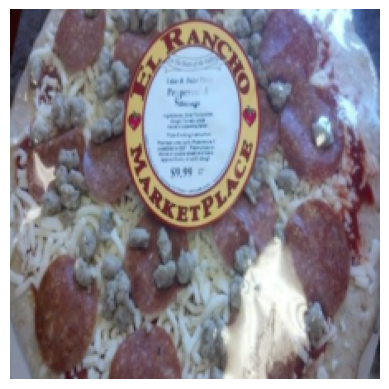

In [63]:
image_batch, label_batch = next(iter(train_dataloader))

test_image,test_label = image_batch[0],label_batch[0]

plt.imshow(test_image.permute(1,2,0))
plt.axis(False)
test_image.shape


In [64]:
height = 224
width = 224
color_channels = 3
patch_size = 16


N = int((height*width)/patch_size**2)
N

196

In [65]:
embedding_layer_input_size = (height,width,color_channels)
embedding_layer_output_size = (N,(patch_size**2)*color_channels)


print(f"Input Size(2D) {embedding_layer_input_size}")
print(f"Output Size(1D) {embedding_layer_output_size}")


Input Size(2D) (224, 224, 3)
Output Size(1D) (196, 768)


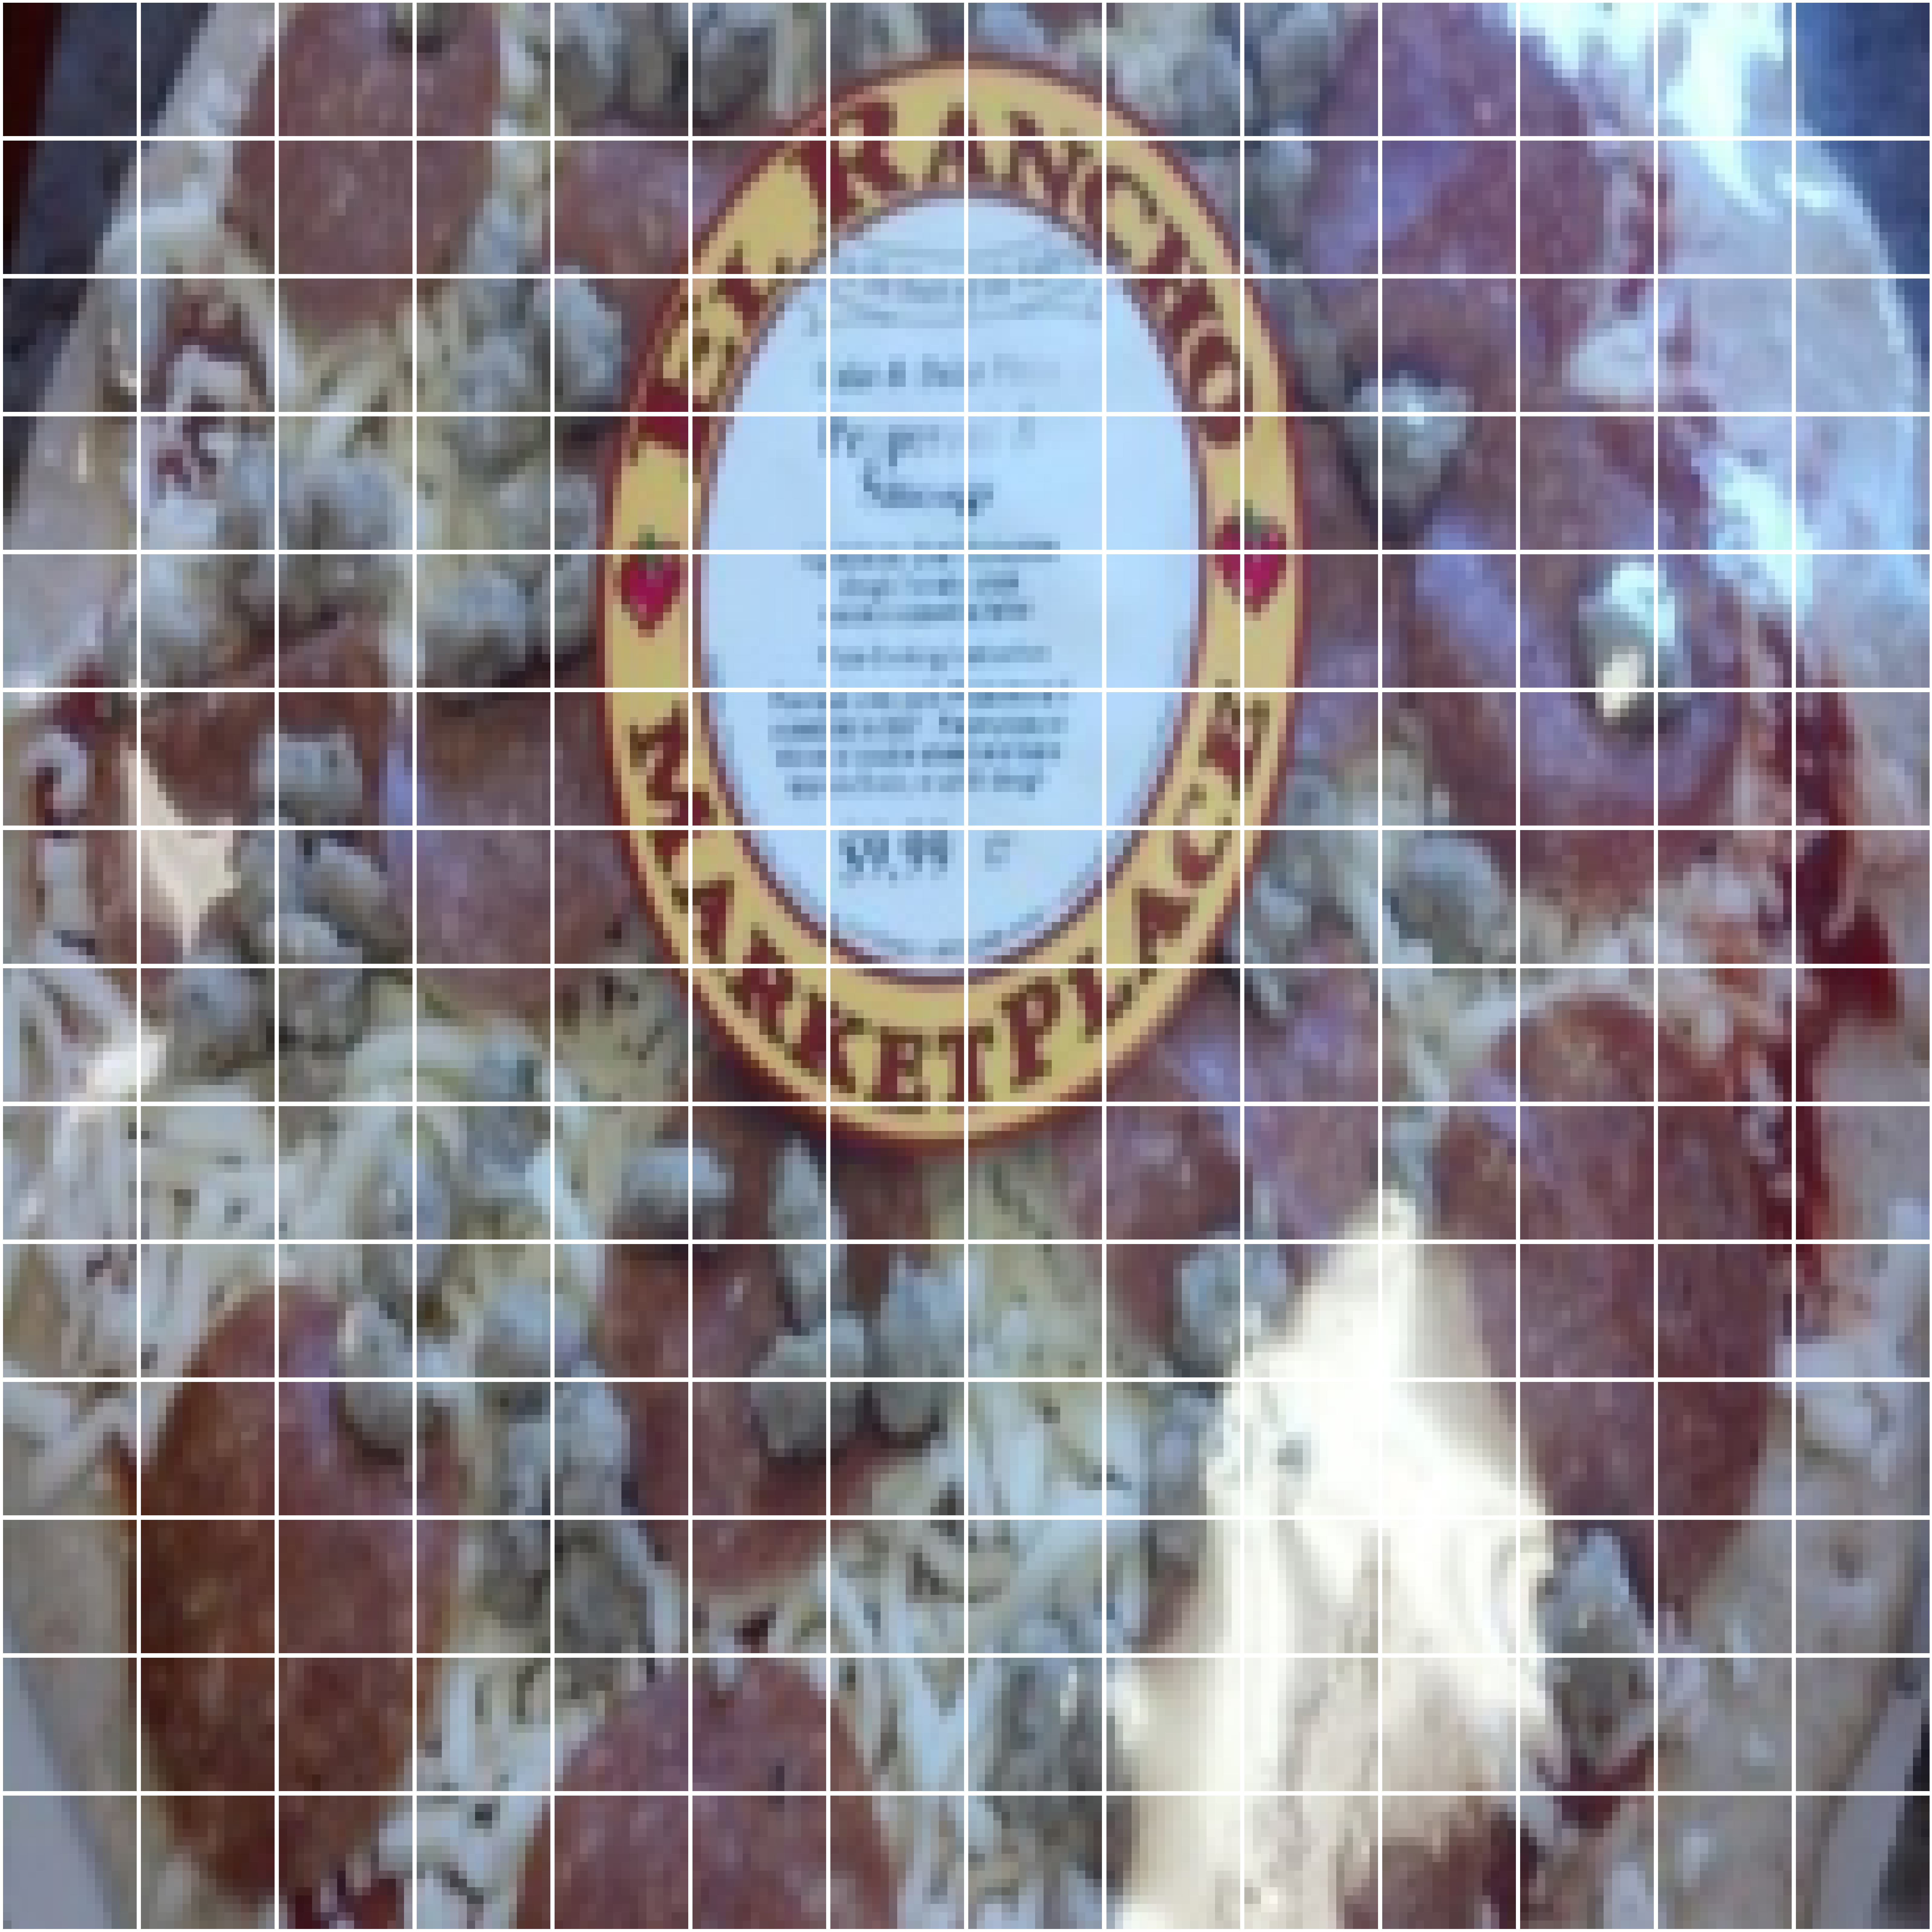

In [104]:
img_size = 224
num_patches = img_size//patch_size
k=1
plt.figure(figsize=(64,64))
for i in range(0,num_patches):
    for j in range(0,num_patches):
        plt.subplot(num_patches,num_patches,k)
        plt.imshow(test_image.permute(1,2,0)[patch_size*i:patch_size*i+16,patch_size*j:patch_size*j+16,:])
        plt.axis(False)
        plt.tight_layout()
        k+=1

In [ ]:
conv_layer = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)
conv_layer

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [72]:
image_passed_in_conv = conv_layer(test_image.unsqueeze(0))
image_passed_in_conv.shape

torch.Size([1, 768, 14, 14])

In [94]:
class Permute(nn.Module):
    
    def __init__(self,dims):
        super().__init__()
        self.dims = dims
        
    def forward(self,x):
        x = x.permute(self.dims)
        return x
    
embed_layer = nn.Sequential(
    nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
),
    nn.Flatten(start_dim=2,end_dim=3),
    Permute([0,2,1])
)

image_passed_in_embed = embed_layer(test_image.unsqueeze(0))
image_passed_in_embed.shape

torch.Size([1, 196, 768])

(-0.5, 195.5, 0.5, -0.5)

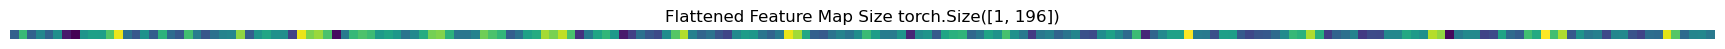

In [95]:
image_passed_in_embed = image_passed_in_embed[:,:,0]
plt.figure(figsize=(22,22))
plt.imshow(image_passed_in_embed.detach().numpy())
plt.title(f"Flattened Feature Map Size {image_passed_in_embed.shape}")
plt.axis(False)

In [97]:
class PatchEmbedding(nn.Module):
    
    def __init__(self,in_channels,patch_size,embedding_dim):
        super().__init__()
        
        
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            padding=0,
            stride=patch_size,
            kernel_size=patch_size
        )
        
        self.flatten = nn.Flatten(
            start_dim=2,
            end_dim=3
        )
    
    def forward(self,x):
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        return x_flattened.permute(0,2,1)

In [106]:
patchify= PatchEmbedding(in_channels=3,patch_size=16,embedding_dim=768)


print(f"Input Image Size:{test_image.shape}")
patchified_image = patchify(test_image.unsqueeze(0))
print(f"Ouput Image Size:{patchified_image.shape}")

Input Image Size:torch.Size([3, 224, 224])
Ouput Image Size:torch.Size([1, 196, 768])


In [108]:
batch_size = patchified_image.shape[0]
embedding_dimension = patchified_image.shape[-1]

batch_size,embedding_dimension

(1, 768)

In [117]:
class_token = nn.Parameter(torch.randn(batch_size,1,embedding_dimension))
class_token.shape

torch.Size([1, 1, 768])

In [118]:
patchified_image.shape

torch.Size([1, 196, 768])

In [119]:
patchified_image_with_class_token = torch.cat((class_token,patchified_image),dim=1)
patchified_image_with_class_token

tensor([[[-1.2099, -1.0246, -0.0303,  ...,  0.1820, -0.3069, -1.2856],
         [ 0.0209, -0.1273,  0.0017,  ...,  0.0968, -0.0862,  0.0375],
         [ 0.0820, -0.2533,  0.1804,  ...,  0.1074, -0.2328,  0.1565],
         ...,
         [-0.0217, -0.2858,  0.1943,  ...,  0.1580, -0.1935,  0.0481],
         [-0.0623, -0.3264,  0.1226,  ...,  0.0856, -0.3373,  0.0621],
         [-0.0216, -0.1197,  0.0674,  ..., -0.0213, -0.2226,  0.0290]]],
       grad_fn=<CatBackward0>)

In [121]:
N,embedding_dimension

(196, 768)

In [122]:
position_embedding = nn.Parameter(torch.ones(
    1,N+1,embedding_dimension
))

position_embedding,position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [126]:
patch_and_pos_embed = patchified_image_with_class_token+position_embedding
patch_and_pos_embed,patch_and_pos_embed.shape

(tensor([[[-0.2099, -0.0246,  0.9697,  ...,  1.1820,  0.6931, -0.2856],
          [ 1.0209,  0.8727,  1.0017,  ...,  1.0968,  0.9138,  1.0375],
          [ 1.0820,  0.7467,  1.1804,  ...,  1.1074,  0.7672,  1.1565],
          ...,
          [ 0.9783,  0.7142,  1.1943,  ...,  1.1580,  0.8065,  1.0481],
          [ 0.9377,  0.6736,  1.1226,  ...,  1.0856,  0.6627,  1.0621],
          [ 0.9784,  0.8803,  1.0674,  ...,  0.9787,  0.7774,  1.0290]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))